In [1]:
%pip install matplotlib numpy numba

Note: you may need to restart the kernel to use updated packages.


# GridWorld Class

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from matplotlib.patches import Rectangle


class GridWorld:
    def __init__(
        self,
        rows,
        cols,
        goal_state,
        trap_state,
        obstacle_states,
        tunnel_connections=None,
    ):
        self.rows = rows
        self.cols = cols
        self.goal = tuple(goal_state)
        self.trap = tuple(trap_state)
        self.obstacles = set(tuple(obs) for obs in obstacle_states)
        self.tunnels = set()
        if tunnel_connections:
            for a, b in tunnel_connections:
                self.tunnels.add((tuple(a), tuple(b)))
                self.tunnels.add((tuple(b), tuple(a)))
        self.state = None

    def reset(self):
        self.state = (1, 1)

    def step(self, action):
        if self.state is None:
            raise ValueError("Call reset() before step().")

        proposed_state = self._get_next_state(self.state, action)

        if self._is_valid_state(proposed_state):
            self.state = proposed_state
        else:
            proposed_state = self.state

        reward = self._get_reward(self.state)
        done = self._is_terminal_state(self.state)

        return self.state, reward, done

    def _get_next_state(self, state, action):
        row, col = state
        moves = {
            "N": (row - 1, col),
            "S": (row + 1, col),
            "E": (row, col + 1),
            "W": (row, col - 1),
        }
        return moves.get(action, state)

    def _is_valid_state(self, state):
        row, col = state

        if not (1 <= row <= self.rows and 1 <= col <= self.cols):
            return False

        if state in self.obstacles:
            return False

        if self.tunnels:
            if self.state is not None:
                if abs(self.state[1] - col) == 1 and self.state[0] == row:
                    if (self.state, state) not in self.tunnels:
                        return False

        return True

    def _is_terminal_state(self, state):
        return state == self.goal or state == self.trap

    def _get_reward(self, state):
        if state == self.goal:
            return 5
        elif state == self.trap:
            return -5
        elif (
            state[0] < 1 or state[1] < 1 or state[0] > self.rows or state[1] > self.cols
        ):
            return -1
        return 0

# Training Function

In [67]:
def get_state_id(coords, rows, cols):
    return (coords[0] - 1) * cols + coords[1]


def get_action_from_index(action_idx):
    return ["N", "S", "E", "W"][action_idx]

@jit(nopython=True)
def softmax_sample(probs):
    cumulative = 0.0
    r = np.random.rand()
    for i in range(len(probs)):
        cumulative += probs[i]
        if r < cumulative:
            return i
    return len(probs) - 1


@jit(nopython=True)
def train_q_numpy(
    grid,
    goal_state,
    trap_state,
    num_episodes=100000,
    alpha=0.1,
    gamma=0.9,
    tau=1.0,
    epsilon=0.1,
    use_softmax=True,
    max_steps=200,
    seed=42,
):
    np.random.seed(seed)
    rows, cols = grid.shape
    num_states = rows * cols
    num_actions = 4  # [W, E, S, N] index
    Q = 0.001 * np.random.rand(num_states, num_actions)
    episode_steps = np.zeros(num_episodes)

    def state_id(row, col):
        return row * cols + col

    actions = np.array([[-1, 0], [1, 0], [0, 1], [0, -1]])  # N, S, E, W

    for ep in range(num_episodes):
        row, col = 1, 1
        state = state_id(row, col)
        steps = 0

        for _ in range(max_steps):
            if use_softmax:
                prefs = Q[state] / tau
                max_pref = np.max(prefs)
                exp_prefs = np.exp(prefs - max_pref)
                probs = exp_prefs / np.sum(exp_prefs)
                action_idx = softmax_sample(probs)
            else:
                if np.random.rand() < epsilon:
                    action_idx = np.random.randint(4)
                else:
                    action_idx = np.argmax(Q[state])

            dr, dc = actions[action_idx]
            new_r, new_c = row + dr, col + dc

            # Check boundaries
            if new_r < 0 or new_r >= rows or new_c < 0 or new_c >= cols:
                reward = -1
                Q[state, action_idx] += alpha * (reward - Q[state, action_idx])
                steps += 1
                continue

            if grid[new_r, new_c] == -1:
                reward = -1
                Q[state, action_idx] += alpha * (reward - Q[state, action_idx])
                steps += 1
                continue

            next_state = state_id(new_r, new_c)

            if (new_r, new_c) == goal_state:
                reward = 5
                Q[state, action_idx] += alpha * (reward - Q[state, action_idx])
                break
            elif (new_r, new_c) == trap_state:
                reward = -5
                Q[state, action_idx] += alpha * (reward - Q[state, action_idx])
                break
            else:
                reward = 0
                td_target = reward + gamma * np.max(Q[next_state])
                Q[state, action_idx] += alpha * (td_target - Q[state, action_idx])
                row, col = new_r, new_c
                state = next_state

            steps += 1

        episode_steps[ep] = steps

    return Q, episode_steps


def create_flat_grid(rows, cols, obstacles):
    grid = np.zeros((rows, cols), dtype=np.int32)
    for r, c in obstacles:
        grid[r, c] = -1
    return grid


def gridworld_to_numpy_inputs(env):
    grid = create_flat_grid(
        env.rows, env.cols, [(r - 1, c - 1) for (r, c) in env.obstacles]
    )
    goal = (env.goal[0] - 1, env.goal[1] - 1)
    trap = (env.trap[0] - 1, env.trap[1] - 1)
    obstacles = [(r - 1, c - 1) for (r, c) in env.obstacles]
    return grid, goal, trap, obstacles

# Utility Methods

In [70]:
def extract_policy_and_value(Q, env):
    policy = np.zeros((env.rows, env.cols), dtype=int)
    value_function = np.zeros((env.rows, env.cols))

    for i in range(env.rows):
        for j in range(env.cols):
            coords = [i + 1, j + 1]
            state = get_state_id(coords, env.rows, env.cols)

            if tuple(coords) in env.obstacles:
                policy[i, j] = -1
                value_function[i, j] = 0
                continue

            if tuple(coords) == env.goal:
                policy[i, j] = -1
                value_function[i, j] = 5
                continue

            if tuple(coords) == env.trap:
                policy[i, j] = -1
                value_function[i, j] = -5
                continue

            policy[i, j] = np.argmax(Q[state - 1])
            value_function[i, j] = np.max(Q[state - 1])

    return policy, value_function


def plot_value_function(
    value_fn,
    env,
    title="Value Function",
    figsize=(6, 5),
    fontsize=14,
    highlight_tunnel=True,
):
    masked_value = value_fn.copy()
    valid_tunnel_cells = set()
    tunnel_rows = set()
    tunnel_cols = set()

    if hasattr(env, "tunnels") and highlight_tunnel:
        for a, b in env.tunnels:
            valid_tunnel_cells.add(tuple(a))
            valid_tunnel_cells.add(tuple(b))
            if abs(a[1] - b[1]) == 1:
                tunnel_cols.add(min(a[1], b[1]) + 1)
            elif abs(a[0] - b[0]) == 1:
                tunnel_rows.add(min(a[0], b[0]) + 1)

    for i in range(env.rows):
        for j in range(env.cols):
            cell = (i + 1, j + 1)

            # Mask obstacles
            if cell in env.obstacles:
                masked_value[i, j] = np.nan
                continue

            # Mask tunnel region columns except valid tunnel cells
            if cell[1] in tunnel_cols and cell not in valid_tunnel_cells:
                masked_value[i, j] = np.nan
                continue

    plt.figure(figsize=figsize)
    cmap = plt.get_cmap("hot")
    cmap.set_bad(color="white")

    im = plt.imshow(
        masked_value,
        cmap=cmap,
        interpolation="nearest",
        origin="upper",
        extent=(0.5, env.cols + 0.5, env.rows + 0.5, 0.5),
    )
    plt.title(title)
    plt.colorbar(im, label="Value")

    g_row, g_col = env.goal
    t_row, t_col = env.trap

    plt.text(
        g_col,
        g_row,
        "G",
        color="lime",
        ha="center",
        va="center",
        fontsize=fontsize,
        fontweight="bold",
    )
    plt.text(
        t_col,
        t_row,
        "T",
        color="red",
        ha="center",
        va="center",
        fontsize=fontsize,
        fontweight="bold",
    )

    for obs in env.obstacles:
        plt.gca().add_patch(
            Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1, color="black")
        )

    if env.state:
        plt.plot(env.state[1], env.state[0], "o", color="blue", markersize=15)
        plt.text(
            env.state[1],
            env.state[0],
            "A",
            color="white",
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold",
        )

    plt.xticks(np.arange(1, env.cols + 1))
    plt.yticks(np.arange(1, env.rows + 1))
    plt.grid(False)
    plt.tight_layout()
    plt.show()


def plot_policy_grid(policy, env, title="Converged Policy", figsize=(8, 5)):
    fig, ax = plt.subplots(figsize=figsize)

    # Grid lines
    for i in range(1, env.rows):
        ax.axhline(i, color="k", linewidth=1)
    for j in range(1, env.cols):
        ax.axvline(j, color="k", linewidth=1)

    # Obstacles
    for obs in env.obstacles:
        ax.plot(obs[1] - 0.5, obs[0] - 0.5, "ks", markerfacecolor="k", markersize=40)

    # Goal
    ax.plot(
        env.goal[1] - 0.5, env.goal[0] - 0.5, "gs", markerfacecolor="g", markersize=40
    )

    # Trap
    ax.plot(
        env.trap[1] - 0.5, env.trap[0] - 0.5, "rs", markerfacecolor="r", markersize=40
    )

    # Policy arrows
    direction_map = {
        0: (0, -0.3),  # West
        1: (0, 0.3),  # East
        2: (0.3, 0),  # South
        3: (-0.3, 0),  # North
    }

    for i in range(env.rows):
        for j in range(env.cols):
            cell = (i + 1, j + 1)

            # Skip non-navigable cells
            if cell in env.obstacles or cell == env.goal or cell == env.trap:
                continue

            tunnel_cells = set()
            if hasattr(env, "tunnels"):
                for t1, t2 in env.tunnels:
                    tunnel_cells.add(tuple(t1))
                    tunnel_cells.add(tuple(t2))

            if env.cols == 11 and cell[1] == 6 and cell not in tunnel_cells:
                continue

            action = policy[i, j]
            if action in direction_map:
                dx, dy = direction_map[action]
                ax.arrow(
                    j + 0.5,
                    i + 0.5,
                    dx,
                    dy,
                    head_width=0.1,
                    head_length=0.1,
                    fc="k",
                    ec="k",
                )

    if env.goal:
        ax.plot(
            env.goal[1] - 0.5,
            env.goal[0] - 0.5,
            "o",
            markerfacecolor="blue",
            markeredgecolor="white",
            markersize=30,
        )

    ax.set_xlim((0, env.cols))
    ax.set_ylim((env.rows, 0))
    ax.set_xticks(np.arange(1, env.cols + 1))
    ax.set_yticks(np.arange(1, env.rows + 1))
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.grid(True)
    plt.tight_layout()
    plt.show()


def create_env(
    rows, cols, goal_state, trap_state, obstacle_states, tunnel_connections=None
):
    return GridWorld(
        rows=rows,
        cols=cols,
        goal_state=goal_state,
        trap_state=trap_state,
        obstacle_states=obstacle_states,
        tunnel_connections=tunnel_connections,
    )


def moving_average(data, window=1000):
    return np.convolve(data, np.ones(window) / window, mode="valid")


def moving_average_fewer_point(arr, window):
    return [np.mean(arr[i : i + window]) for i in range(0, len(arr), window)]

# Assignment Part 1 Setup

In [75]:
n = 5
num_episodes = 100000
goal_state = [n, n]
trap_state = [3, 5]
obstacle_states = [
    [1, 4],
    [2, 2],
    [3, 3],
    [5, 3],
]

## Question 1: Final Value Function & Policy

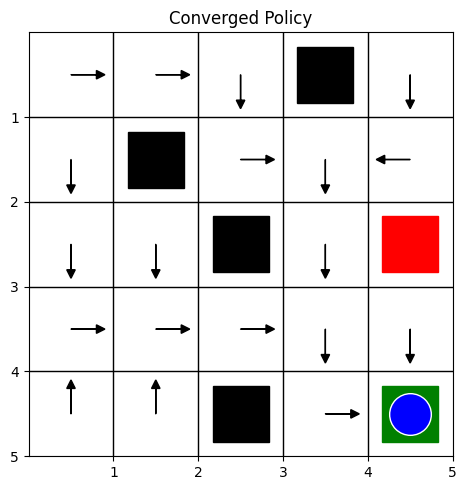

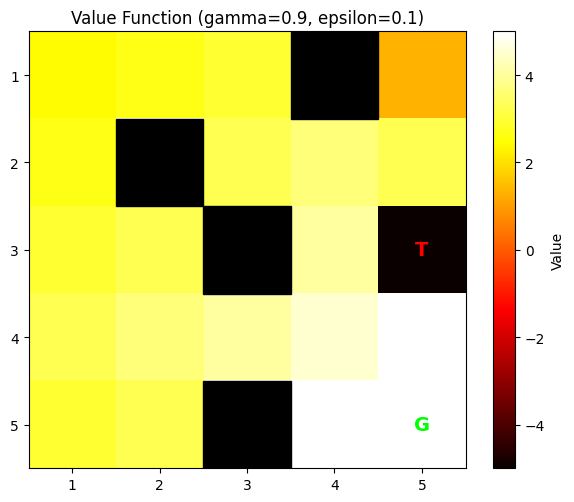

In [76]:
q1_env = create_env(n, n, goal_state, trap_state, obstacle_states)

grid, goal, trap, obstacles = gridworld_to_numpy_inputs(q1_env)
Q1, steps1 = train_q_numpy(
    grid,
    goal,
    trap,
    num_episodes=num_episodes,
    epsilon=0.1,
    alpha=0.1,
    gamma=0.9,
    seed=42,
    use_softmax=False,
)
policy1, value_fn1 = extract_policy_and_value(Q1, q1_env)
plot_policy_grid(policy1, q1_env)
print()
plot_value_function(value_fn1, q1_env, title="Value Function (gamma=0.9, epsilon=0.1)")

## Question 2: Varying Gamma

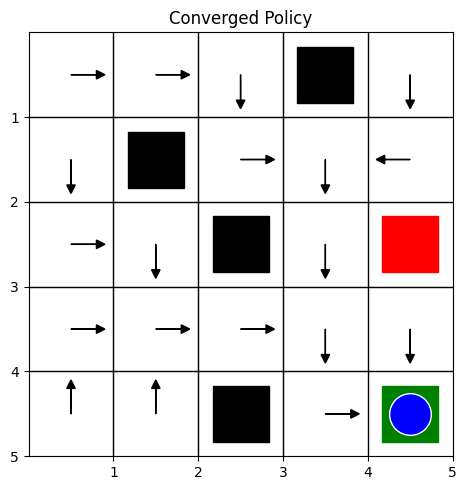

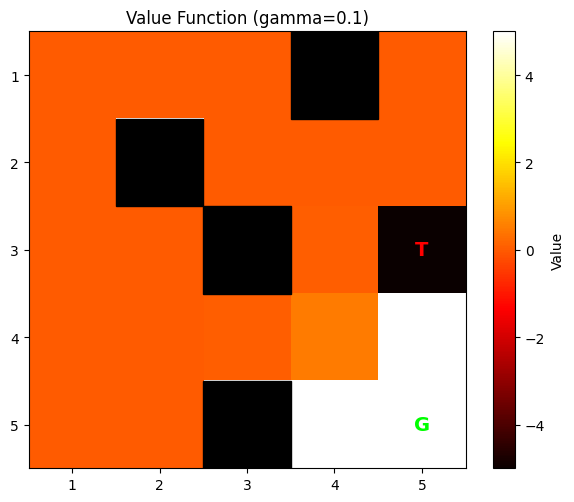

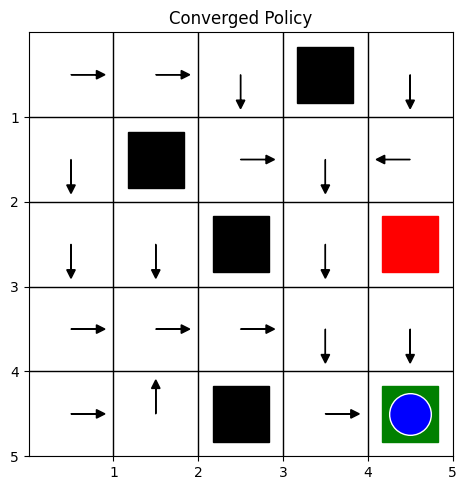

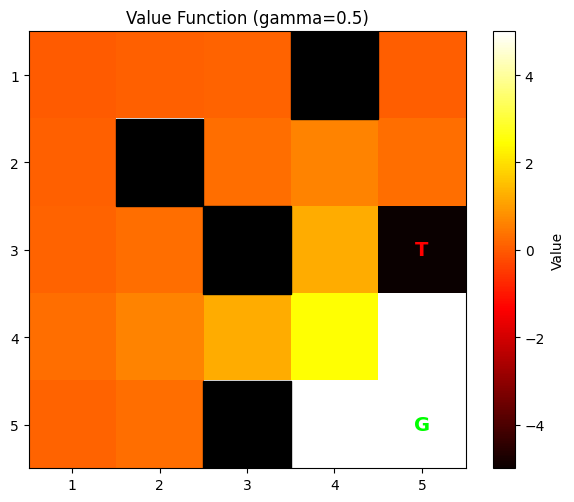

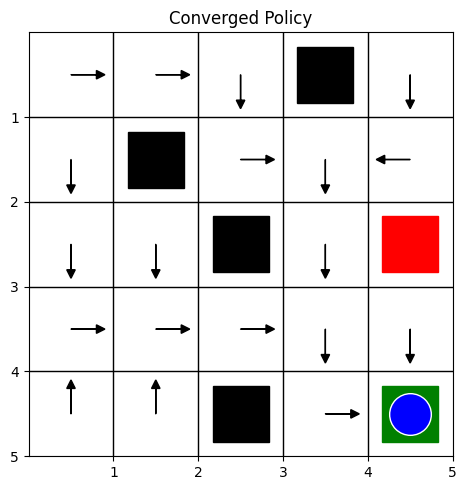

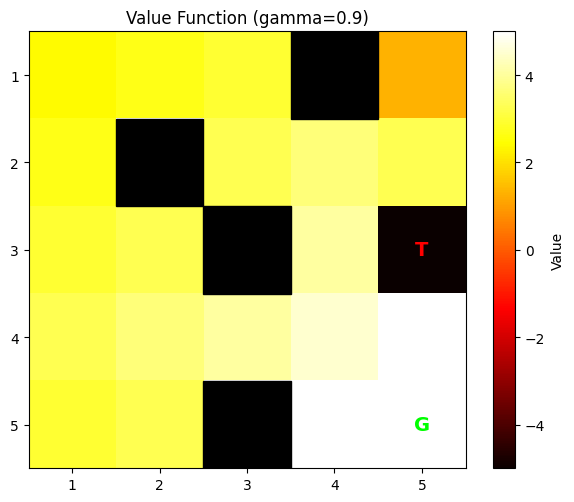

In [77]:
gamma_values = [0.1, 0.5, 0.9]
all_steps = {}
for gamma in gamma_values:
    env = create_env(n, n, goal_state, trap_state, obstacle_states)
    grid, goal, trap, obstacles = gridworld_to_numpy_inputs(env)
    Q, steps = train_q_numpy(
        grid,
        goal,
        trap,
        num_episodes=num_episodes,
        epsilon=0.1,
        alpha=0.1,
        gamma=gamma,
        seed=42,
        use_softmax=False,
    )
    policy, value_fn = extract_policy_and_value(Q, env)

    plot_policy_grid(policy, env)
    print()
    plot_value_function(value_fn, env, title=f"Value Function (gamma={gamma})")
    print()
    all_steps[gamma] = steps

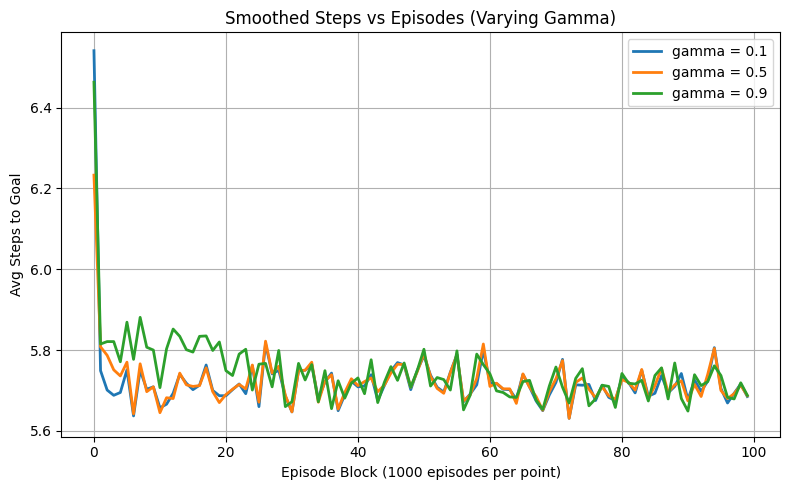

In [78]:
plt.figure(figsize=(8, 5))
for gamma, steps in all_steps.items():
    avg_steps = moving_average_fewer_point(steps, window=1000)
    plt.plot(avg_steps, label=f"gamma = {gamma}", linewidth=2)
plt.title("Smoothed Steps vs Episodes (Varying Gamma)")
plt.xlabel("Episode Block (1000 episodes per point)")
plt.ylabel("Avg Steps to Goal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Question 3: Varying Epsilon and Fixed Gamma 0.9

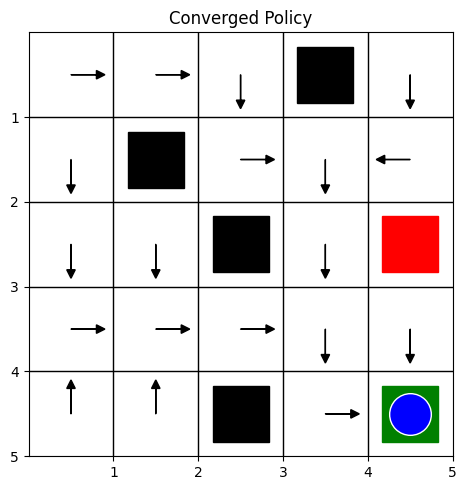

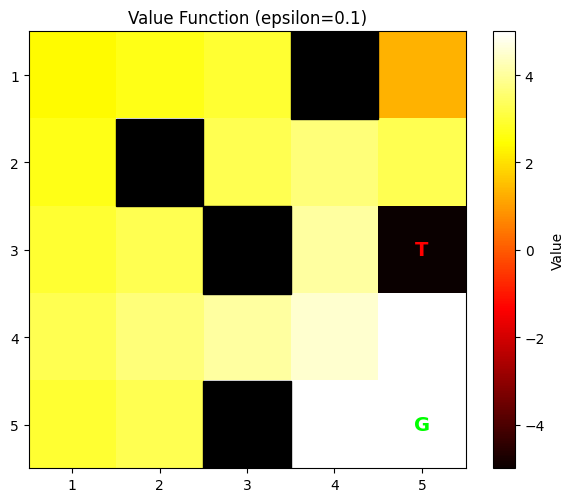

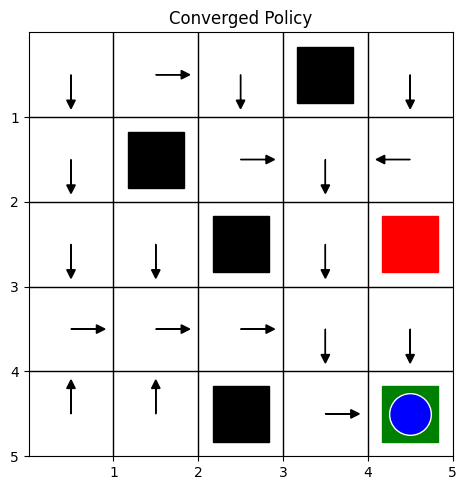

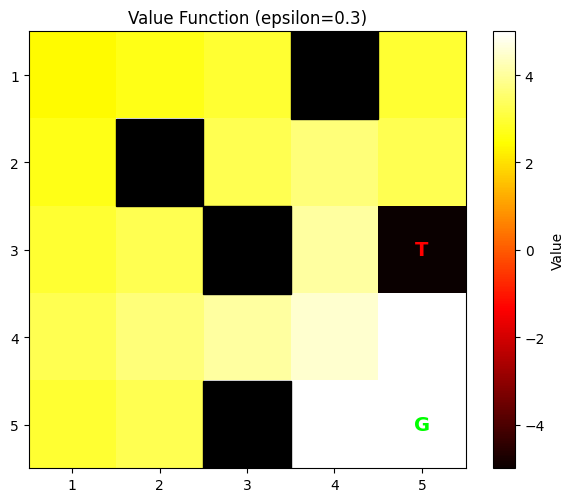

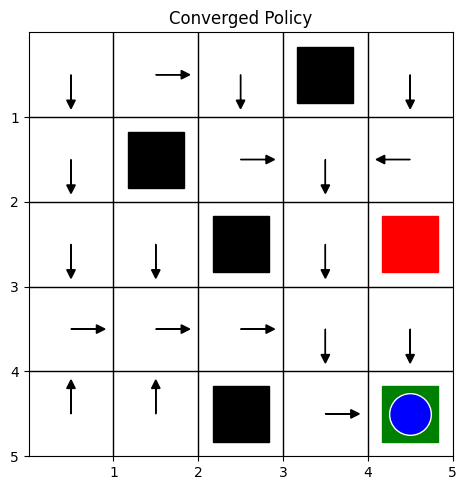

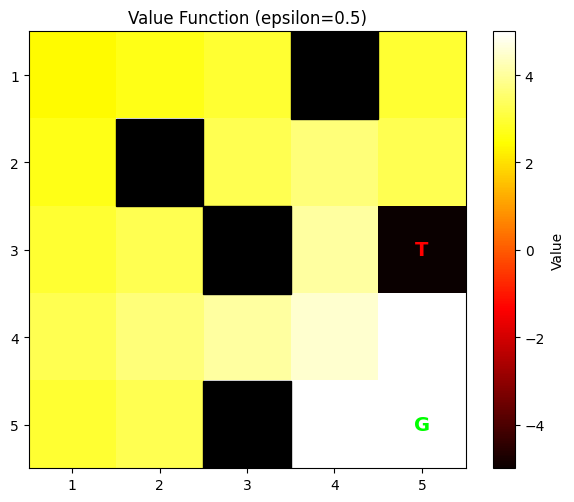

In [79]:
epsilon_values = [0.1, 0.3, 0.5]
all_eps_steps = {}
for eps in epsilon_values:
    env = create_env(n, n, goal_state, trap_state, obstacle_states)
    grid, goal, trap, obstacles = gridworld_to_numpy_inputs(env)
    Q, steps = train_q_numpy(
        grid,
        goal,
        trap,
        num_episodes=num_episodes,
        epsilon=eps,
        alpha=0.1,
        gamma=0.9,
        seed=42,
        use_softmax=False,
    )
    policy, value_fn = extract_policy_and_value(Q, env)
    plot_policy_grid(policy, env)
    print()
    plot_value_function(value_fn, env, title=f"Value Function (epsilon={eps})")
    print()
    all_eps_steps[eps] = steps

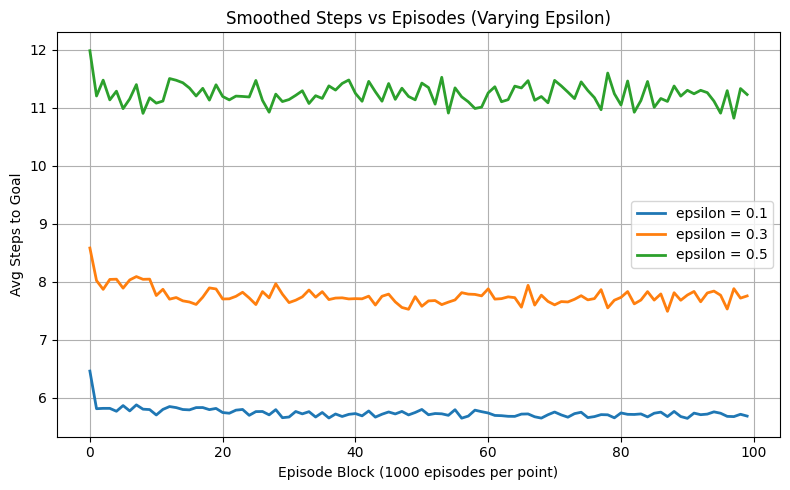

In [80]:
plt.figure(figsize=(8, 5))
for eps, steps in all_eps_steps.items():
    avg_steps = moving_average_fewer_point(steps, window=1000)
    plt.plot(avg_steps, label=f"epsilon = {eps}", linewidth=2)
plt.title("Smoothed Steps vs Episodes (Varying Epsilon)")
plt.xlabel("Episode Block (1000 episodes per point)")
plt.ylabel("Avg Steps to Goal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Assignment Part 2 Setup

In [81]:
grid_rows = 5
grid_cols = 11
num_episodes = 200000
part2_goal_state = [5, 11]
part2_trap_state = [4, 7]
part2_obstacle_states = [
    [2, 3],
    [3, 3],
    [4, 3],
    [3, 9],
    [3, 10],
    [5, 9],
]
tunnels = [((3, 5), (3, 6))]

## Question 1: Final Value Function & Policy

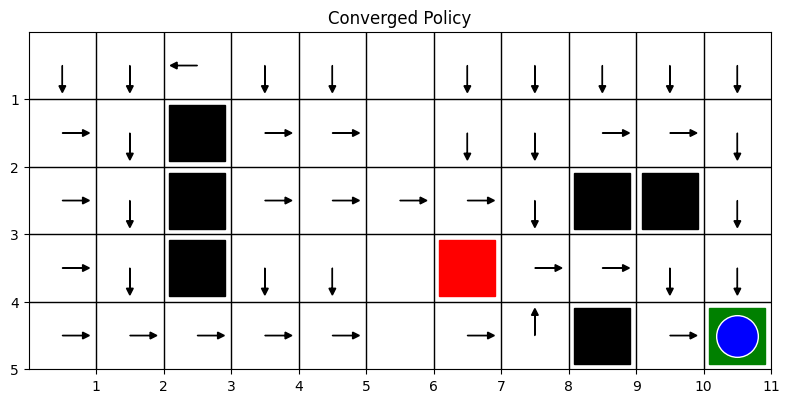

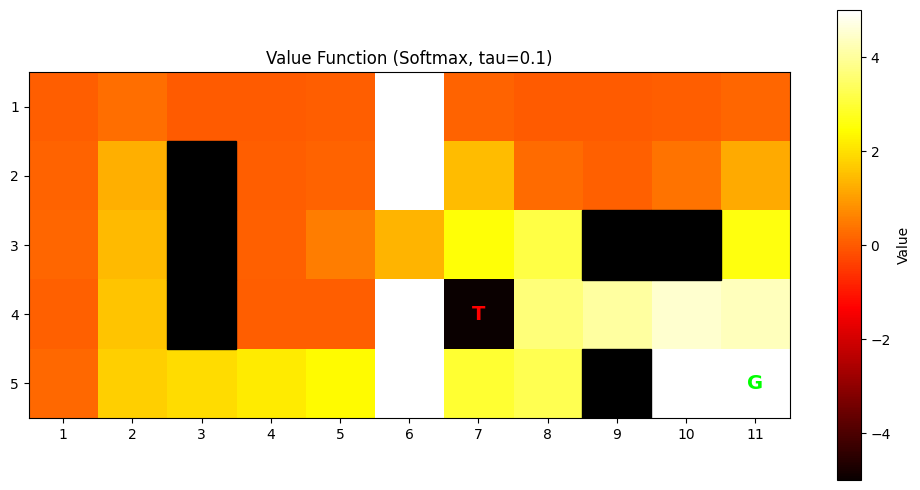

In [82]:
part2_q1_env = create_env(
    grid_rows,
    grid_cols,
    part2_goal_state,
    part2_trap_state,
    part2_obstacle_states,
    tunnel_connections=tunnels,
)

grid, goal, trap, obstacles = gridworld_to_numpy_inputs(part2_q1_env)
part2_Q1, part2_steps1 = train_q_numpy(
    grid,
    goal,
    trap,
    num_episodes=num_episodes,
    tau=0.1,
    alpha=0.1,
    gamma=0.9,
    seed=42,
)
part2_policy1, part2_value_fn1 = extract_policy_and_value(part2_Q1, part2_q1_env)

plot_policy_grid(part2_policy1, part2_q1_env, figsize=(8, 5))
print()
plot_value_function(
    part2_value_fn1,
    part2_q1_env,
    title="Value Function (Softmax, tau=0.1)",
    figsize=(10, 5),
)

## Question 2: Varying Gamma

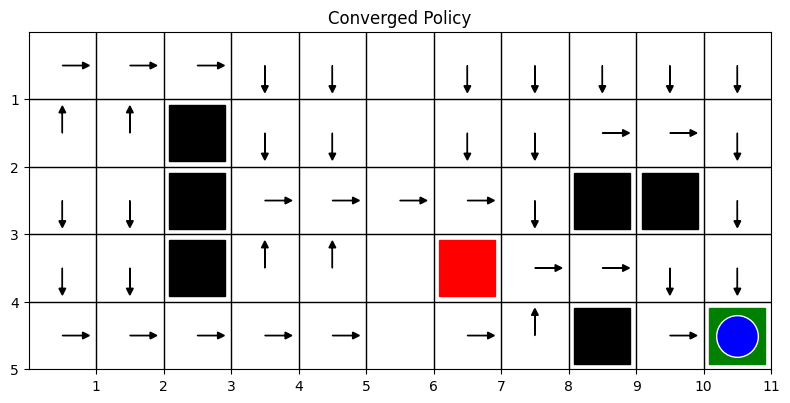

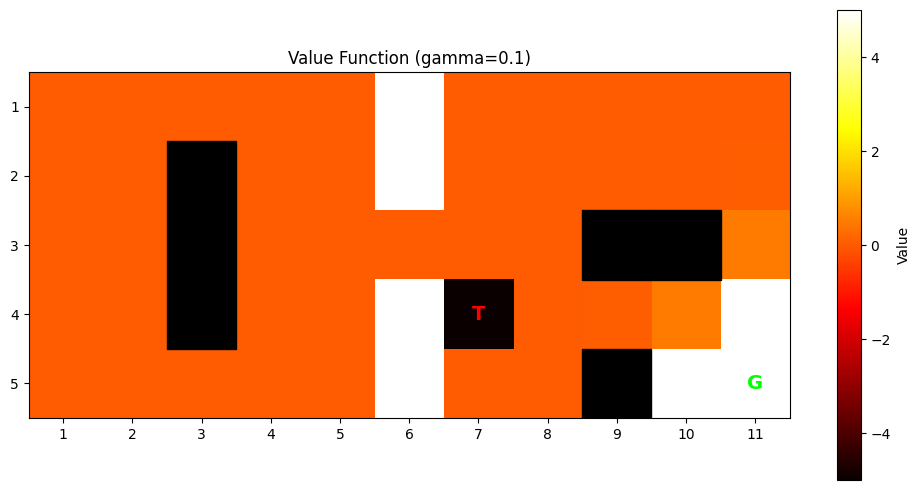

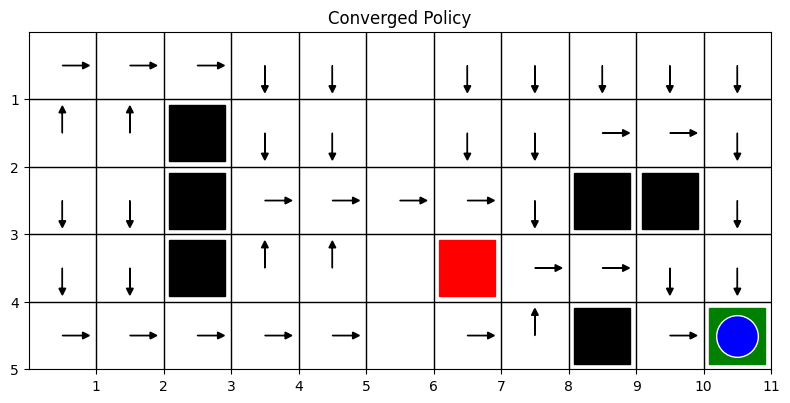

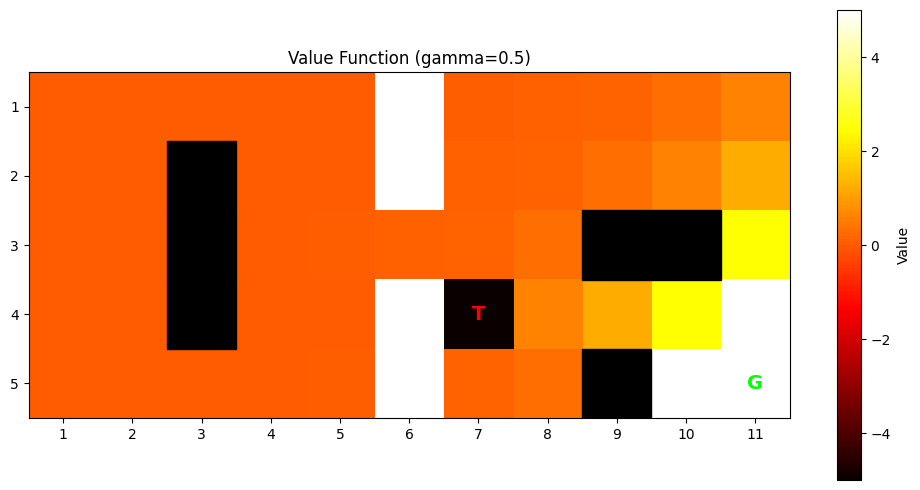

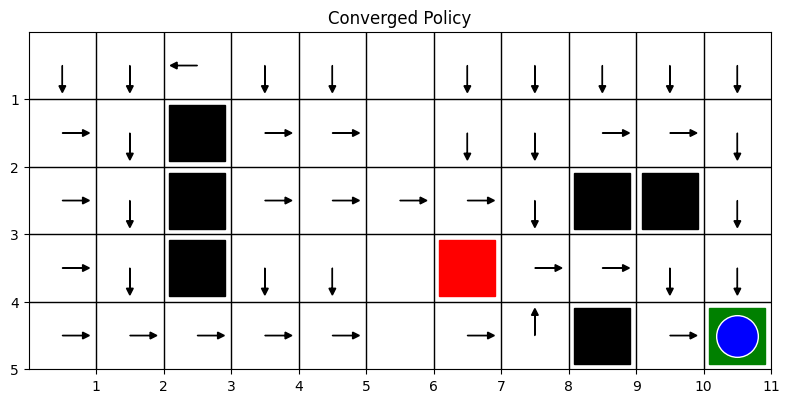

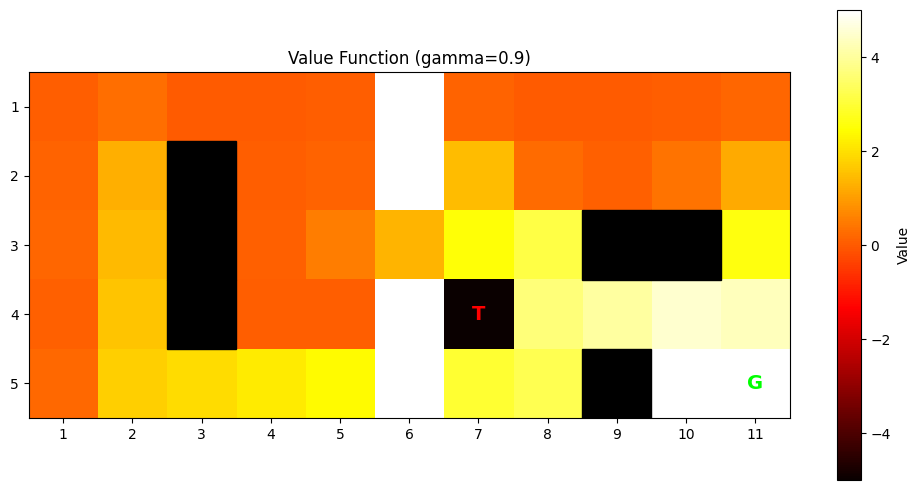

In [83]:
gamma_values = [0.1, 0.5, 0.9]
part2_q2_all_steps = {}
for gamma in gamma_values:
    env = create_env(
        grid_rows,
        grid_cols,
        part2_goal_state,
        part2_trap_state,
        part2_obstacle_states,
        tunnel_connections=tunnels,
    )
    grid, goal, trap, obstacles = gridworld_to_numpy_inputs(env)
    Q, steps = train_q_numpy(
        grid,
        goal,
        trap,
        num_episodes=num_episodes,
        tau=0.1,
        alpha=0.1,
        gamma=gamma,
        seed=42,
    )
    policy, value_fn = extract_policy_and_value(Q, env)
    plot_policy_grid(policy, env, figsize=(8, 5))
    print()
    plot_value_function(
        value_fn, env, title=f"Value Function (gamma={gamma})", figsize=(10, 5)
    )
    print()
    part2_q2_all_steps[gamma] = steps

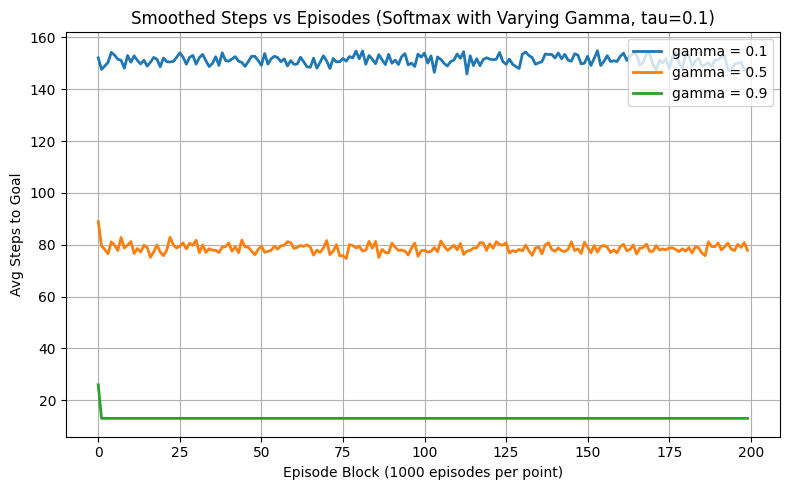

In [84]:
plt.figure(figsize=(8, 5))
for gamma, steps in part2_q2_all_steps.items():
    smoothed = moving_average_fewer_point(steps, window=1000)
    plt.plot(smoothed, label=f"gamma = {gamma}", linewidth=2)
plt.title("Smoothed Steps vs Episodes (Softmax with Varying Gamma, tau=0.1)")
plt.xlabel("Episode Block (1000 episodes per point)")
plt.ylabel("Avg Steps to Goal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Question 3: Varying Tau

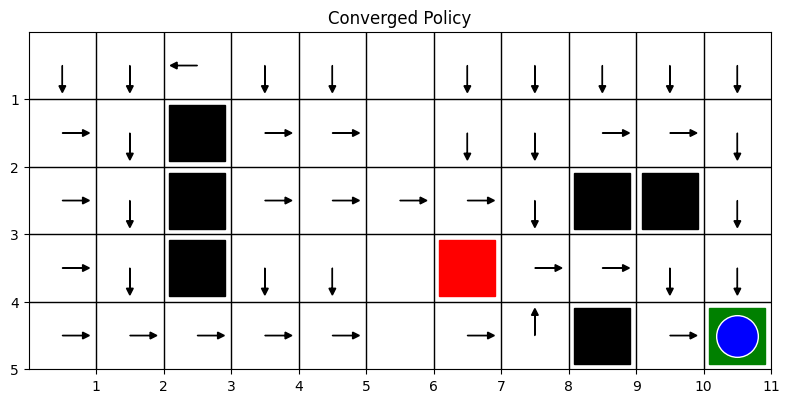

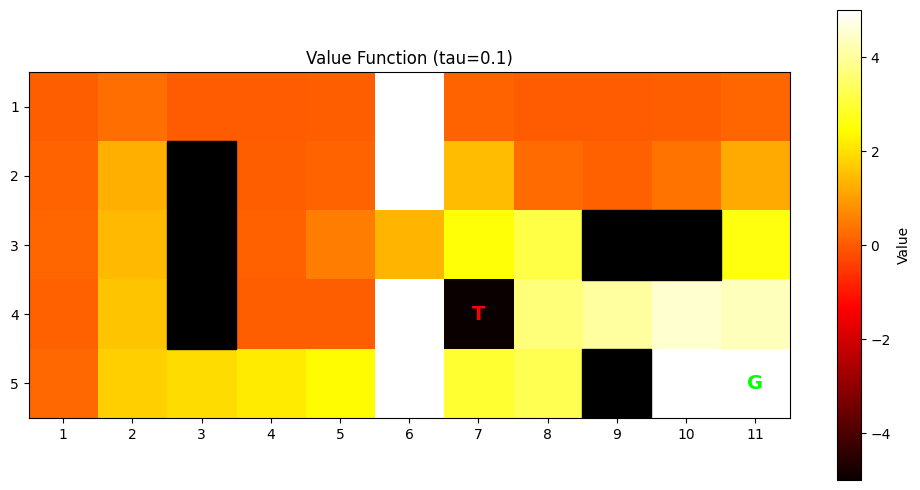

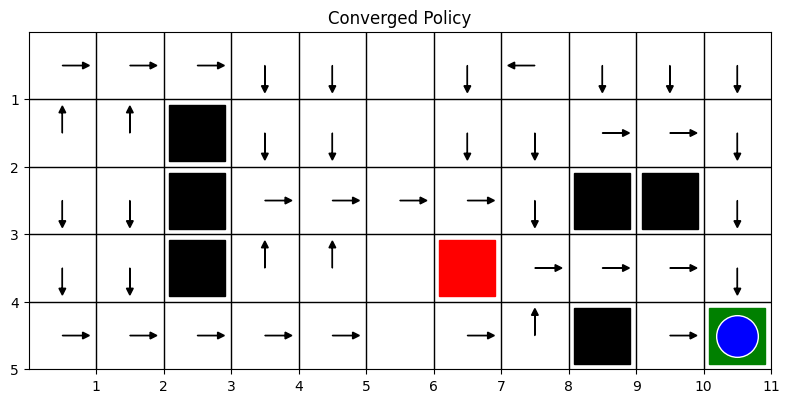

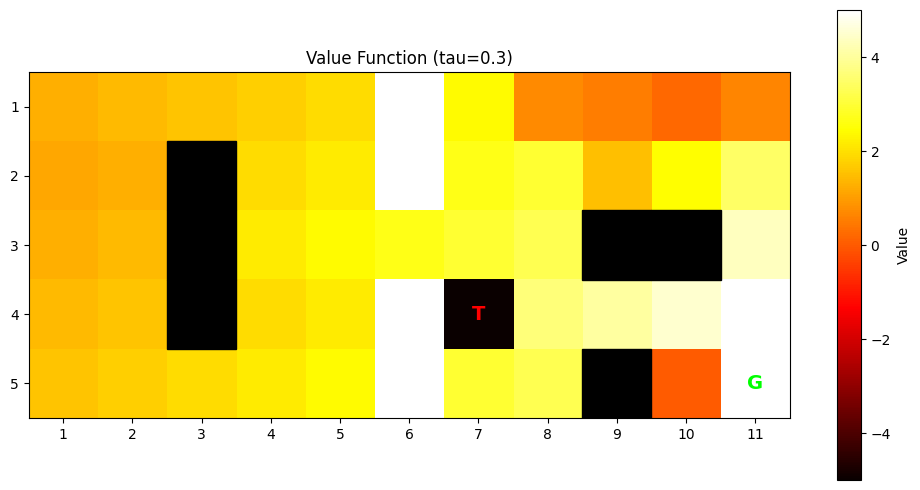

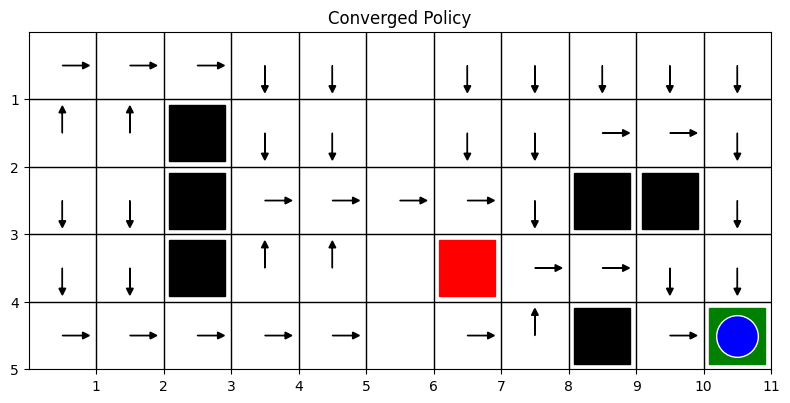

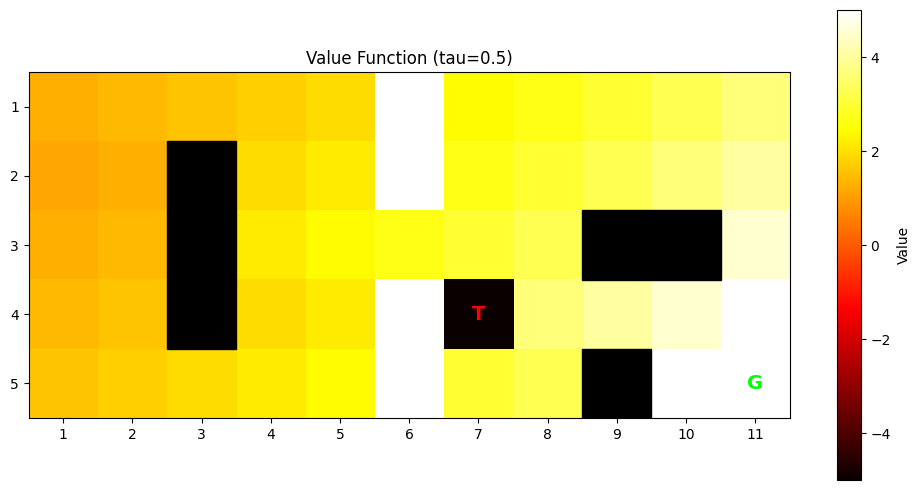

In [85]:
tau_values = [0.1, 0.3, 0.5]
all_steps = {}
for tau in tau_values:
    env = create_env(
        grid_rows,
        grid_cols,
        part2_goal_state,
        part2_trap_state,
        part2_obstacle_states,
        tunnel_connections=tunnels,
    )
    grid, goal, trap, obstacles = gridworld_to_numpy_inputs(env)
    Q, steps = train_q_numpy(
        grid,
        goal,
        trap,
        num_episodes=num_episodes,
        tau=tau,
        alpha=0.1,
        gamma=0.9,
        seed=42,
    )
    policy, value_fn = extract_policy_and_value(Q, env)
    plot_policy_grid(policy, env, figsize=(8, 5))
    print()
    plot_value_function(
        value_fn, env, title=f"Value Function (tau={tau})", figsize=(10, 5)
    )
    print()
    all_steps[tau] = steps

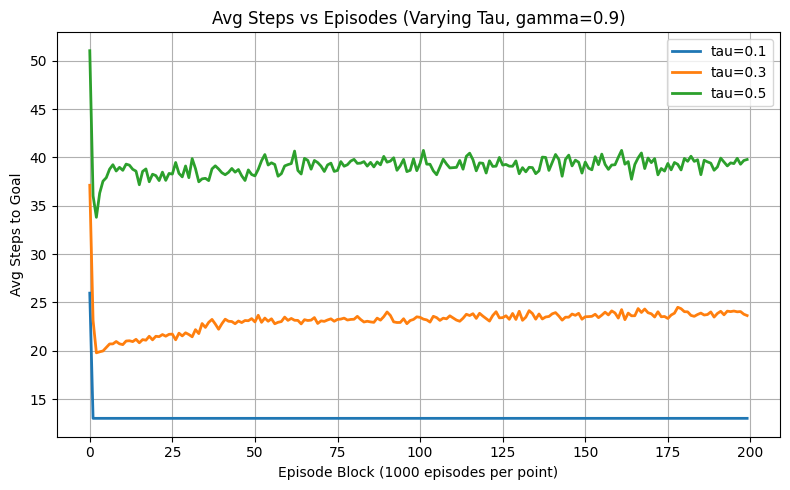

In [86]:
plt.figure(figsize=(8, 5))
for tau, steps in all_steps.items():
    avg_steps = moving_average_fewer_point(steps, window=1000)
    plt.plot(avg_steps, label=f"tau={tau}", linewidth=2)

plt.title("Avg Steps vs Episodes (Varying Tau, gamma=0.9)")
plt.xlabel("Episode Block (1000 episodes per point)")
plt.ylabel("Avg Steps to Goal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()